# Post-process model output

In [1]:
%load_ext autoreload
%autoreload 2

In [80]:
from glob import glob
import yaml

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import cesm_tools

In [34]:
case = 'cam6327_sd.apo_test_srf_emis.002'
with open(f"caseinfo/{case}.yml") as fid:
    caseinfo = yaml.safe_load(fid)
    
srf_emis_files = caseinfo['srf_emis_files']    
archive_root = caseinfo['archive_root']    

In [4]:
with xr.open_dataset(caseinfo['ncdata']) as ds:
    background_ppm = ds.attrs['cam_i_add_uniform_fields_background_ppm']
background_ppm

400.0

In [5]:
fincl_specifer = caseinfo['fincl2lonlat_dict']
fincl_specifer

{'alt': '62.507w_82.451n',
 'brw': '156.611w_71.323n',
 'cba': '162.720w_55.210n',
 'cgo': '144.690e_40.683s',
 'gould_57S': '64.222w_57.023s',
 'gould_59S': '63.317w_59.026s',
 'gould_61S': '60.621w_61.042s',
 'gould_63S': '61.123w_63.077s',
 'gould_65S': '63.855w_64.785s',
 'kum': '154.888w_19.561n',
 'ljo': '117.257w_32.867n',
 'mlo': '155.576w_19.536n',
 'psa': '64.053w_64.774s',
 'smo': '170.564w_14.247s',
 'spo': '24.800w_89.980s'}

In [33]:
# additional tracers
tracers = list(srf_emis_files.keys())    
tracers

['apo_jena',
 'co2_cesm',
 'co2_gridfed',
 'co2_oco2mip',
 'co2_somffn',
 'n2_cesm',
 'n2_era',
 'o2_cesm',
 'o2_gk01r16',
 'o2_gridfed']

In [7]:
f"{archive_root}/{case}.cam.h1.????-??-??-00000.nc"

'/glade/scratch/mclong/archive/cam6327_sd.apo_test_srf_emis.002/cam6327_sd.apo_test_srf_emis.002.cam.h1.????-??-??-00000.nc'

In [8]:
def preprocess_cam_h1(ds):
    # reformat to record dimension
    ds = cesm_tools.fincl_lonlat_to_dataset(
        ds, specifer_dict=fincl_specifer, isel_dict={"lev": -1}
    )
    # convert units
    for v in ds.data_vars:
        if v in srf_emis_files:
            ds[v] = cesm_tools.tracegas_convert_units(
                ds[v], srf_emis_files[v]["constituent"], background_ppm=background_ppm
            )
    return ds


ds = xr.open_mfdataset(
    f"{archive_root}/atm/hist/{case}.cam.h1.????-??-??-00000.nc",
    preprocess=preprocess_cam_h1,
)
ds.info()

xarray.Dataset {
dimensions:
	ilev = 57 ;
	time = 125 ;
	record = 15 ;

variables:
	float64 lev() ;
		lev:long_name = hybrid level at midpoints (1000*(A+B)) ;
		lev:units = hPa ;
		lev:positive = down ;
		lev:standard_name = atmosphere_hybrid_sigma_pressure_coordinate ;
		lev:formula_terms = a: hyam b: hybm p0: P0 ps: PS ;
	float64 ilev(ilev) ;
		ilev:long_name = hybrid level at interfaces (1000*(A+B)) ;
		ilev:units = hPa ;
		ilev:positive = down ;
		ilev:standard_name = atmosphere_hybrid_sigma_pressure_coordinate ;
		ilev:formula_terms = a: hyai b: hybi p0: P0 ps: PS ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
		time:bounds = time_bnds ;
	<U9 record(record) ;
	float32 co2_gridfed(record, time) ;
		co2_gridfed:mdims = 1 ;
		co2_gridfed:units = ppm ;
		co2_gridfed:mixing_ratio = dry ;
		co2_gridfed:long_name = co2_gridfed concentration ;
		co2_gridfed:cell_methods = time: mean ;
		co2_gridfed:basename = co2_gridfed ;
	float32 o2_gk01r16(record, time) ;
		o2_gk01r16:mdims =

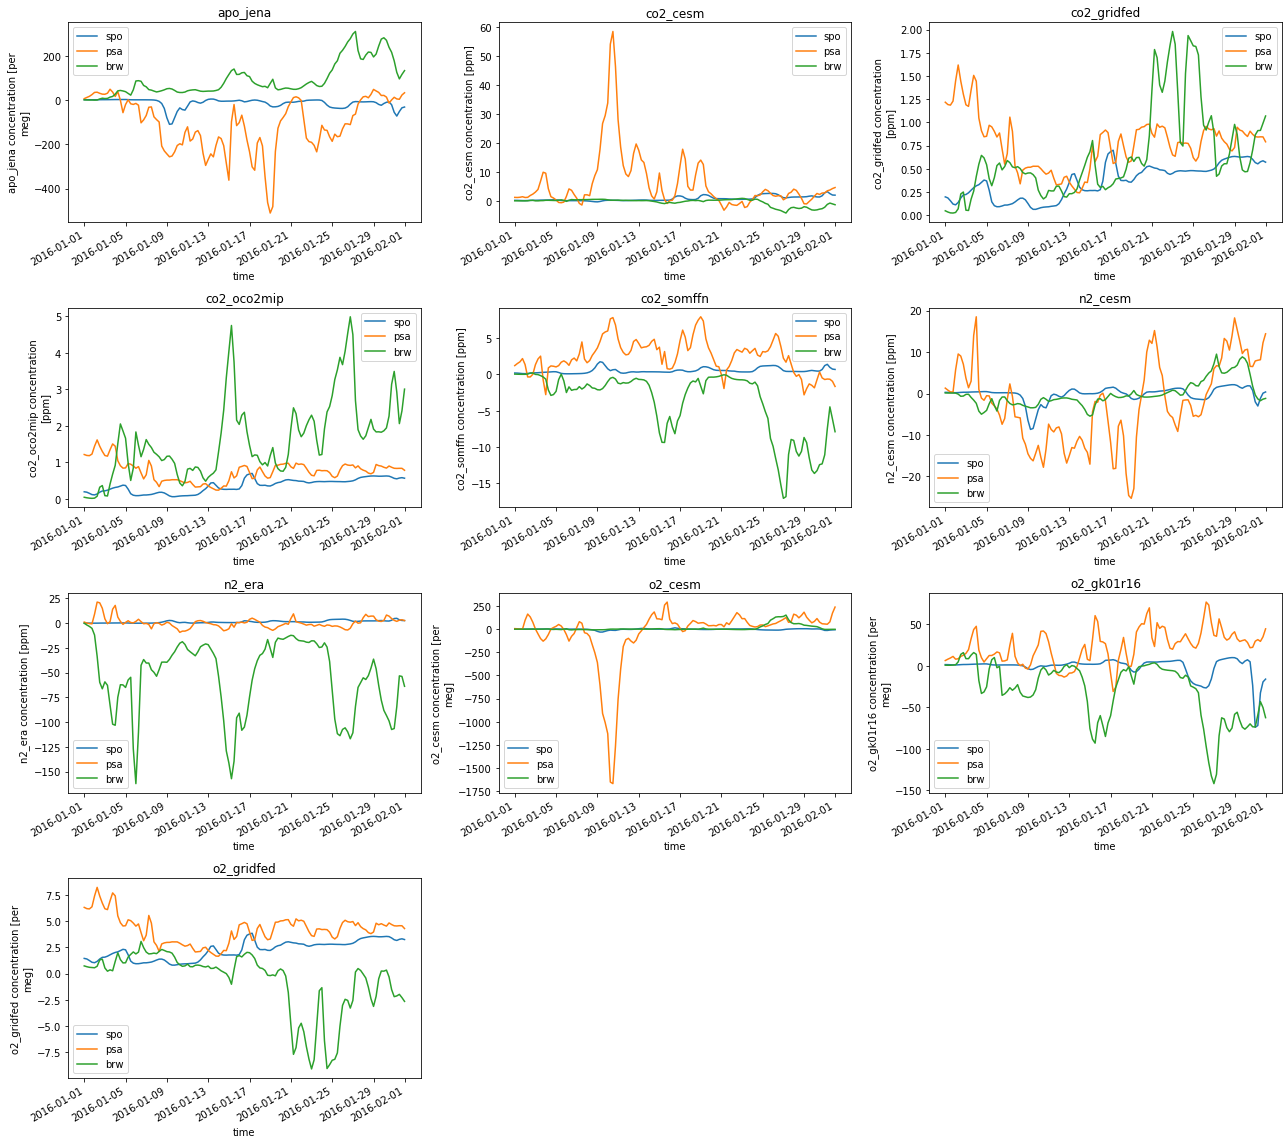

In [9]:
n = len(tracers)
ncol = int(np.sqrt(n))
nrow = int(((n / ncol) + n % ncol))

fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 6, nrow * 4))
for n, v in enumerate(tracers):
    i, j = np.unravel_index(n, axs.shape)
    ax = axs[i, j]
    for stn in ["spo", "psa", "brw"]:
        ds[v].sel(record=stn).plot(label=stn, ax=ax)
    ax.legend()
    ax.set_title(v)

for ni in range(n+1, ncol*nrow):
    i, j = np.unravel_index(ni, axs.shape)
    axs[i, j].remove()
plt.tight_layout()


In [162]:
def preprocess_cam_h0(ds):
    return ds.set_coords([v for v in ds.variables if "time" not in ds[v].dims])

files = sorted(glob(f"{archive_root}/atm/hist/{case}.cam.h0.????-??-??-00000.nc"))
ds = xr.open_mfdataset(
    files,
    concat_dim="time",
    coords="minimal",
    compat="override",
    use_cftime=True,
    preprocess=preprocess_cam_h0,
    attrs_file=files[0],
)

num_time = cftime.date2num(
    ds.time, 
    units='days since 1980-01-01 00:00:00',
)
dt = np.diff(num_time)[0]
assert (dt == np.diff(num_time)).all()

area = cesm_tools.get_area(ds, 'atm')

ds

<xarray.Dataset>
Dimensions:           (lat: 192, lon: 288, lev: 56, ilev: 57, time: 125, nbnd: 2)
Coordinates: (12/16)
  * lat               (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon               (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    gw                (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
  * lev               (lev) float64 1.868 2.353 2.948 ... 962.5 977.5 992.5
    hyam              (lev) float64 dask.array<chunksize=(56,), meta=np.ndarray>
    hybm              (lev) float64 dask.array<chunksize=(56,), meta=np.ndarray>
    ...                ...
  * time              (time) object 2016-01-01 00:00:00 ... 2016-02-01 00:00:00
    ndbase            int32 ...
    nsbase            int32 ...
    nbdate            int32 ...
    nbsec             int32 ...
    mdt               int32 ...
Dimensions without coordinates: nbnd
Data variables: (12/415)
    date              (time) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    datesec           (time) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    time_bnds         (time, nbnd) object dask.array<chunksize=(4, 2), meta=np.ndarray>
    date_written      (time) |S8 dask.array<chunksize=(4,), meta=np.ndarray>
    time_written      (time) |S8 dask.array<chunksize=(4,), meta=np.ndarray>
    ndcur             (time) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    ...                ...
    soa_a2SFWET       (time, lat, lon) float32 dask.array<chunksize=(4, 192, 288), meta=np.ndarray>
    soa_a2_SRF        (time, lat, lon) float32 dask.array<chunksize=(4, 192, 288), meta=np.ndarray>
    soa_c1            (time, lev, lat, lon) float32 dask.array<chunksize=(4, 56, 192, 288), meta=np.ndarray>
    soa_c1SFWET       (time, lat, lon) float32 dask.array<chunksize=(4, 192, 288), meta=np.ndarray>
    soa_c2            (time, lev, lat, lon) float32 dask.array<chunksize=(4, 56, 192, 288), meta=np.ndarray>
    soa_c2SFWET       (time, lat, lon) float32 dask.array<chunksize=(4, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              cam6327_sd.apo_test_srf_emis.002
    logname:           mclong
    host:              cheyenne4
    initial_file:      /glade/work/mclong/cam-sd-cases/data/f.e20.FWAMIP.f09_...
    topography_file:   /glade/work/tilmes/inputdata/topo/fv_0.9x1.25_nc3000_N...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_6

In [167]:
ds[[c for c in ds.coords if c not in ['time', 'ndbase', 'nbdate', 'nsbase', 'nbsec', 'mdt',]]].to_netcdf(
    'data/cam_grid.0.9x1.25.nc'
)

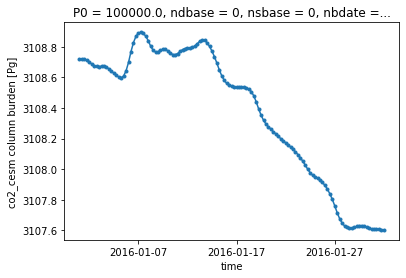

In [144]:
tracer = 'co2_cesm'
mw = cesm_tools.molecular_weights[srf_emis_files[tracer]['constituent']]
with xr.set_options(keep_attrs=True):
    inventory = ds[f'TM{tracer}'].weighted(area).sum(['lat', 'lon'])
    inventory *= 1e-12 # kg --> Pg
    inventory.attrs['units'] = 'Pg'
    
    model_sf = ds[f'SF{tracer}'].weighted(area).sum(['lat', 'lon'])
    model_sf *= 1e-12 # kg --> Pg
    model_sf *= 86000.0 * 365.0 # 1/s --> 1/yr
    model_sf.attrs['units'] = 'Pg/yr'
inventory.plot(marker='.')

In [145]:
1e3 * 1e-15

1e-12

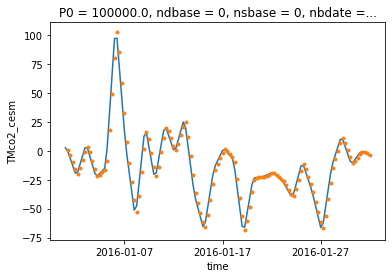

In [146]:
model_sf.plot(label='simulated flux')
(inventory.diff('time') / dt * 365.0).plot(marker='.', label='dInv/dt', linestyle='none')

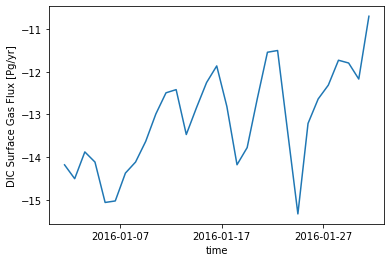

In [159]:
with xr.open_dataset(srf_emis_files[tracer]["flux_file"], use_cftime=True) as dsf:
    
    flux_file_var = srf_emis_files[tracer]["flux_variable"]
    
    with xr.set_options(keep_attrs=True):
        flux = dsf[flux_file_var].sel(time=slice(ds.time[0], ds.time[-1]))
        flux_kgm2s = flux / cesm_tools.molecules_per_mol / cesm_tools.m2_per_cm2 * mw * 1e-3
        flux_kgm2s.attrs['units'] = 'kg/m^2/s'
        flux_integral = (
            flux
            .weighted(dsf.area)
            .sum(["lat", "lon"])
        )
        flux_integral /= cesm_tools.molecules_per_mol 
        flux_integral /= cesm_tools.m2_per_cm2
        flux_integral *= mw * 1e-15
        flux_integral *= 86400.0 * 365.0
        flux_integral.attrs["units"] = "Pg/yr"

flux_integral.plot()

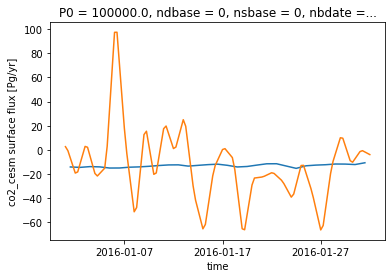

In [148]:
flux_integral.plot()
model_sf.plot()

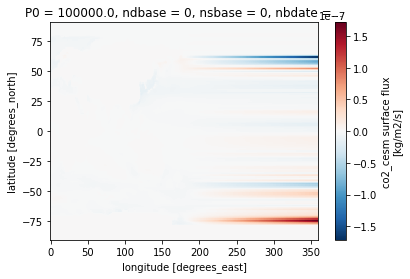

In [161]:
with xr.set_options(keep_attrs=True):
    ds[f'SF{tracer}'].mean('time').plot()

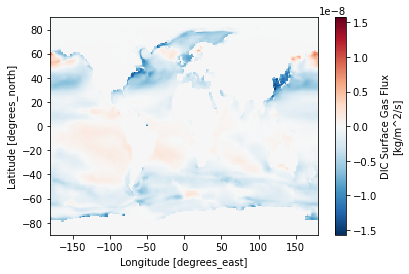

In [160]:
with xr.set_options(keep_attrs=True):
     flux_kgm2s.mean('time').plot()

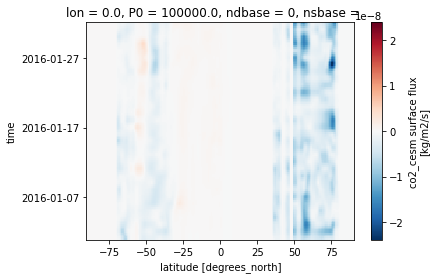

In [151]:
ds[f'SF{tracer}'].isel(lon=0).plot()

In [152]:
dsf.info()

xarray.Dataset {
dimensions:
	time = 12784 ;
	lat = 180 ;
	lon = 360 ;
	d2 = 2 ;
	n_time_components = 6 ;

variables:
	float32 SFCO2_OCN(time, lat, lon) ;
		SFCO2_OCN:long_name = DIC Surface Gas Flux ;
		SFCO2_OCN:units = molecules/cm2/s ;
	float32 area(lat, lon) ;
		area:units = m^2 ;
		area:long_name = area ;
	float64 date(time) ;
		date:units = YYYYMMDD ;
		date:long_name = Date ;
	float64 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = Latitude ;
	float64 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = Longitude ;
	object time(time) ;
		time:bounds = time_bnds ;
	object time_bnds(time, d2) ;
	float32 time_components(time, n_time_components) ;
		time_components:long_name = time components (year, month, day, hour, min, sec) ;
		time_components:units = none ;

// global attributes:
	:model_doi_url = https://doi.org/10.5065/D67H1H0V ;
	:source = g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005 ;
	:note = Leap day values are linearly interpolated from adjacent dat